In [1]:
!pip install -q seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -q imblearn


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, roc_curve, auc

/tmp/ipykernel_14/964055540.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")

In [5]:
X, y = df.drop('0', axis = 1), df['0']
X.shape, y.shape

((372450, 784), (372450,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.25, stratify=y)
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((186225, 784), (93113, 784), (186225,), (93113,))

In [7]:
X_train.isnull().sum(axis=1)

0         0
1         0
2         0
3         0
4         0
         ..
186220    0
186221    0
186222    0
186223    0
186224    0
Length: 186225, dtype: int64

In [8]:
ordinal_to_letter = {i: chr(65 + i) for i in range(26)}

In [9]:
class_indices = {}

for class_label in y_train.unique():
    indices = np.where(y_train == class_label)[0]
    class_indices[class_label] = indices

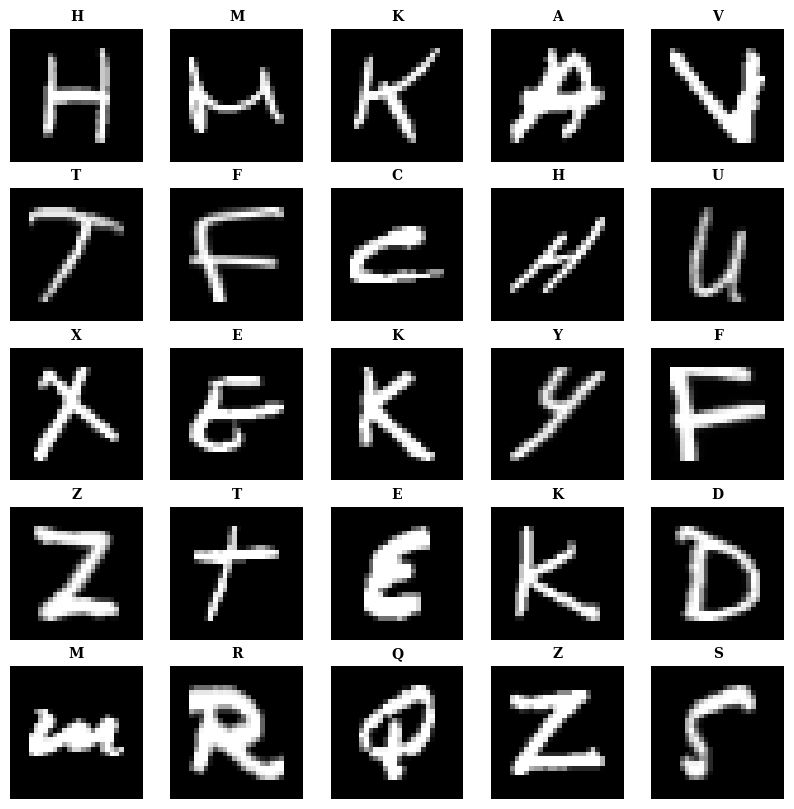

In [10]:
sample_class_indices = np.random.choice(y.nunique(), 25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, sample_class_index in enumerate(sample_class_indices):
    sample_index = np.random.choice(class_indices[sample_class_index])
    image, label = X_train.iloc[sample_index], y_train[sample_index]
    image = image.values.reshape(28, 28)
    ax = axes[i//5][i%5]
    sns.heatmap(image, cmap='gray', square=True, cbar=False, xticklabels=False, yticklabels=False, ax=ax)
    ax.set_title(ordinal_to_letter[label], fontdict={'fontsize': 10, 'fontweight': 'bold', 'fontfamily': 'serif'})

In [11]:
pca = PCA(n_components=2)
components_2d = pca.fit_transform(X_train)


In [12]:
sample_pca_df = []
counter = 0
for class_label, indices in class_indices.items():
    sample_indices = np.random.choice(indices, 200)
    df = pd.DataFrame(components_2d[sample_indices], columns=["PC1", "PC2"])
    label = ordinal_to_letter[class_label]
    df["Label"] = label
    sample_pca_df.append(df)
    
sample_pca_df = pd.concat(sample_pca_df)    

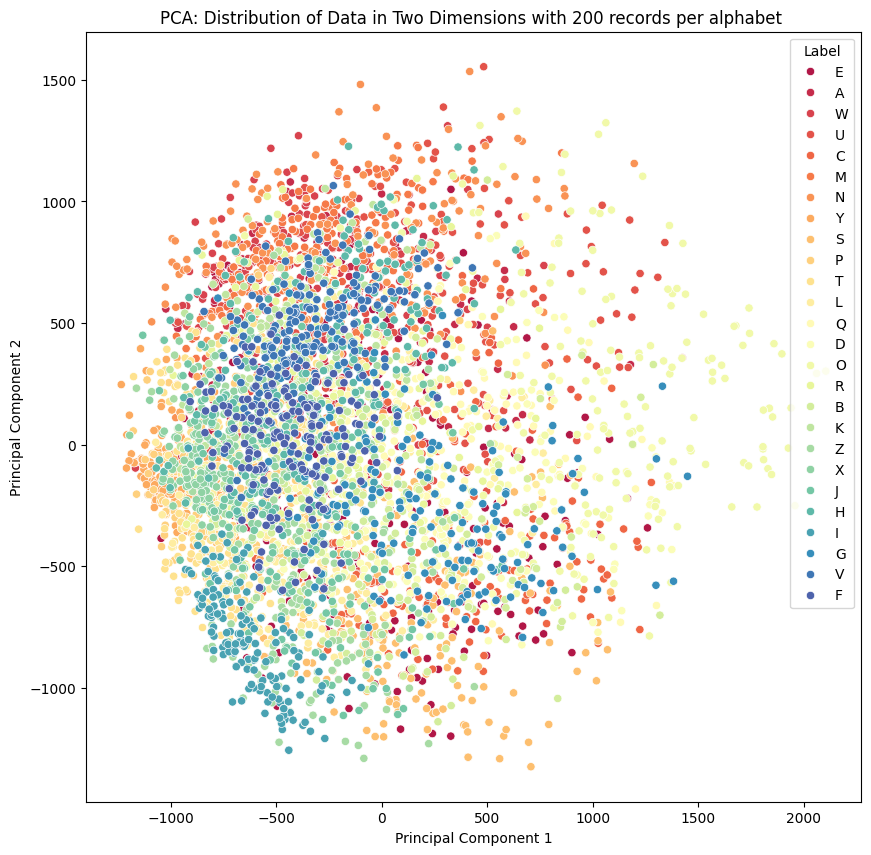

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=sample_pca_df, x="PC1", y="PC2", hue='Label',  palette='Spectral')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Distribution of Data in Two Dimensions with 200 records per alphabet ')
plt.legend(title='Label')
plt.show();

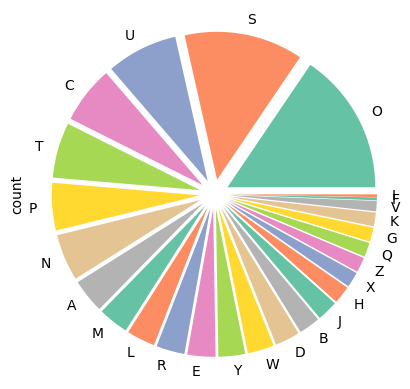

In [14]:
y_value_counts = y_train.value_counts()
y_value_counts.index = y_value_counts.index.map(ordinal_to_letter)
y_value_counts.plot.pie(explode=[0.1]*26, colors=sns.color_palette("Set2"));

In [15]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [16]:
classifiers = [
    ("KNN", KNeighborsClassifier()),
    ("Logistic Regression", LogisticRegression(max_iter=10000)),
    ("Random Forest", RandomForestClassifier(n_jobs=-1)),
    ("Bagging", BaggingClassifier(estimator=KNeighborsClassifier())),
]

In [17]:
classifier_names = []
pipelines = []

for name, classifier in classifiers:
    # Create an imbalanced-learn pipeline for each classifier
    pipeline = ImbPipeline([
        ("SMOTE", SMOTE(random_state=42)),
        ("Scaler", StandardScaler()),
        ("PCA", PCA()),
        ("Classifier", classifier)
    ])
    
    classifier_names.append(name)
    pipelines.append(pipeline)

In [18]:
# Train the classifiers and generate classification reports
import time
for pipeline, name in zip(pipelines, classifier_names):
    print(f'training of {name} is started')
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    print(f'{name} is trained on {np.round(end-start)} seconds')
    y_pred = pipeline.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 75)

training of KNN is started


KNN is trained on 106.0 seconds


Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3468
           1       0.96      0.94      0.95      2167
           2       0.96      0.98      0.97      5852
           3       0.86      0.96      0.90      2533
           4       0.97      0.94      0.96      2860
           5       0.85      0.95      0.89       291
           6       0.93      0.95      0.94      1440
           7       0.90      0.95      0.93      1804
           8       0.97      0.95      0.96       280
           9       0.90      0.96      0.93      2123
          10       0.93      0.93      0.93      1401
          11       0.94      0.98      0.96      2897
          12       0.98      0.97      0.98      3084
          13       0.97      0.96      0.97      4753
          14       0.99      0.96      0.98     14457
          15       0.96      0.98      0.97      4836
          16       0.94      0.94      0.94      1

Logistic Regression is trained on 429.0 seconds


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3468
           1       0.76      0.82      0.79      2167
           2       0.90      0.88      0.89      5852
           3       0.72      0.85      0.78      2533
           4       0.78      0.79      0.79      2860
           5       0.66      0.88      0.75       291
           6       0.67      0.81      0.73      1440
           7       0.66      0.78      0.71      1804
           8       0.56      0.88      0.68       280
           9       0.67      0.83      0.74      2123
          10       0.67      0.80      0.73      1401
          11       0.91      0.94      0.93      2897
          12       0.87      0.88      0.88      3084
          13       0.83      0.76      0.80      4753
          14       0.96      0.91      0.93     14457
          15       0.91      0.90      0.90      4836
          16       0.67      0.82 

Random Forest is trained on 230.0 seconds


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3468
           1       0.91      0.90      0.90      2167
           2       0.96      0.98      0.97      5852
           3       0.90      0.92      0.91      2533
           4       0.95      0.92      0.94      2860
           5       0.93      0.88      0.90       291
           6       0.97      0.90      0.93      1440
           7       0.92      0.87      0.89      1804
           8       0.97      0.90      0.94       280
           9       0.92      0.91      0.91      2123
          10       0.90      0.90      0.90      1401
          11       0.96      0.98      0.97      2897
          12       0.93      0.94      0.93      3084
          13       0.92      0.93      0.93      4753
          14       0.97      0.98      0.98     14457
          15       0.96      0.97      0.97      4836
          16       0.94      0.89      0

Bagging is trained on 186.0 seconds


Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3468
           1       0.97      0.94      0.95      2167
           2       0.96      0.98      0.97      5852
           3       0.86      0.96      0.91      2533
           4       0.97      0.94      0.96      2860
           5       0.85      0.95      0.90       291
           6       0.93      0.95      0.94      1440
           7       0.90      0.95      0.92      1804
           8       0.97      0.95      0.96       280
           9       0.90      0.96      0.93      2123
          10       0.93      0.93      0.93      1401
          11       0.94      0.99      0.96      2897
          12       0.98      0.97      0.97      3084
          13       0.97      0.96      0.97      4753
          14       0.99      0.97      0.98     14457
          15       0.96      0.98      0.97      4836
          16       0.94      0.93      0.94   

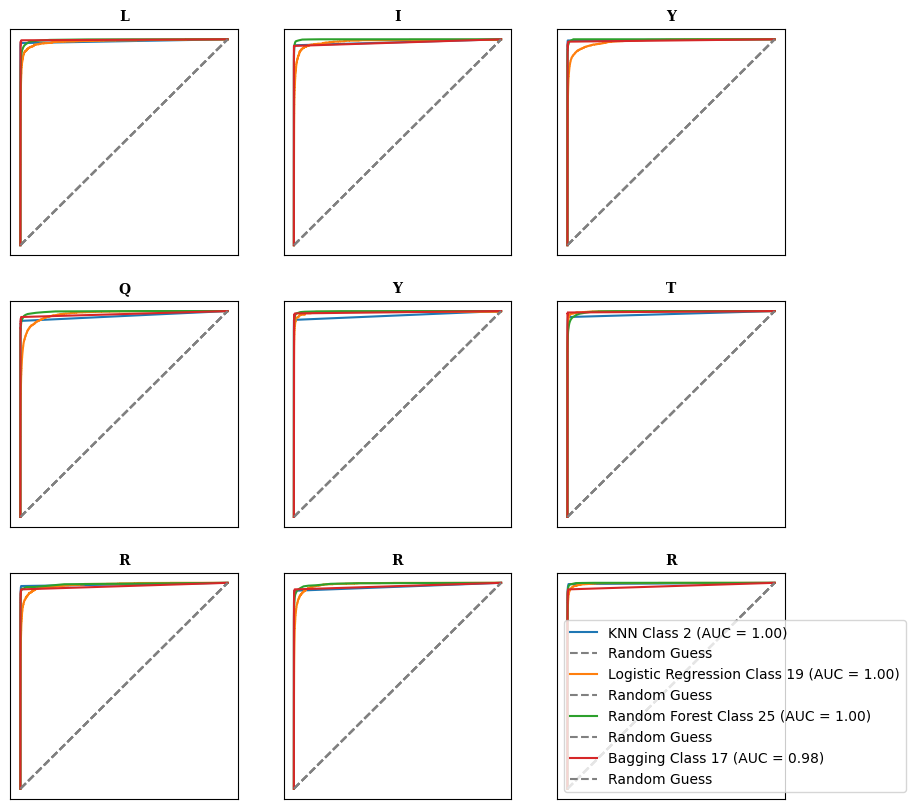

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for pipeline, name in zip(pipelines, classifier_names):
    y_scores = pipeline.predict_proba(X_test)
    n_classes = y_scores.shape[1]
    
    sample_indicies = np.random.choice(range(n_classes), 9)
    for i, sample_index in enumerate(sample_indicies):
        ax = axes[i//3][i%3]
        fpr, tpr, _ = roc_curve(y_test == sample_index, y_scores[:, sample_index])
        roc_auc = roc_auc_score(y_test == sample_index, y_scores[:, sample_index])
        ax.plot(fpr, tpr, label=f'{name} Class {sample_index} (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
        ax.set_title(ordinal_to_letter[sample_index], fontdict={'fontsize': 10, 'fontweight': 'bold', 'fontfamily': 'serif'})
        ax.set_xticks([])
        ax.set_yticks([])
        
ax.legend()
plt.grid(False)
plt.show();